<a href="https://colab.research.google.com/github/MahdiFaourr/MahdiFaourr/blob/main/chest_Xray_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install opendatasets library
!pip install opendatasets

In [ ]:
# Install gradio library
!pip install gradio==3.14.0

In [ ]:
# Import necessary libraries and functions
import opendatasets as od
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense
from tensorflow.keras.metrics import Precision
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import gradio as gr

In [ ]:
# Download the data from kaggle
od.download("https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images?select=chest_xray")

In [ ]:
# RandomSeed42
SEED=42

In [ ]:
# Define the ImageDataGenerator with appropriate preprocessing and augmentation options
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=15,  # Random rotation within the range [-15, 15] degrees
    width_shift_range=0.1,  # Random horizontal shift by up to 10% of the image width
    height_shift_range=0.1,  # Random vertical shift by up to 10% of the image height
    shear_range=0.1,  # Shear intensity (angle in counter-clockwise direction as radians)
    zoom_range=0.1,  # Random zoom by up to 10%
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=False,  # No vertical flip
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)


# Create a generator for reading images from the specified directory
train_generator = datagen.flow_from_directory("/content/labeled-chest-xray-images/chest_xray/train",
    batch_size=32,  # Batch size
    class_mode='binary'  # Since this is a binary classification task
)


# Create a generator for reading images from the specified directory
test_generator = datagen.flow_from_directory("/content/labeled-chest-xray-images/chest_xray/test",
    batch_size=32,
    class_mode='binary'
)


In [ ]:
# Define input shape
input_shape = (256, 256, 3)  #  Input images are 256x256 RGB images

# Define input layer
inputs = Input(shape=input_shape)

# Convolutional layers
layer_1= Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
layer_2 = MaxPooling2D(pool_size=(2, 2))(layer_1)
layer_3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(layer_2)
layer_4 = MaxPooling2D(pool_size=(2, 2))(layer_3)

# Flatten layer
layer_5= Flatten()(layer_4)

# Dense layers
layer_6 = Dense(128, activation='relu')(layer_5)
outputs = Dense(1, activation='sigmoid')(layer_6)  # Output layer with sigmoid activation for binary classification

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision()])

# Print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0     

In [ ]:
# Define a checkpoint callback to save the best weights
checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train your model with the callback
history=model.fit(train_generator,validation_data=(test_generator),epochs=12,batch_size=len(train_generator),callbacks=[checkpoint])

In [ ]:
# Load the best weights into your model
model.load_weights('best_weights.h5')

In [ ]:
# Evaluate the model over test_generator
model.evaluate(test_generator)

20/20 [==============================] - 36s 2s/step - loss: 0.2550 - accuracy: 0.9054 - precision: 0.9190


[0.2549540102481842, 0.9054487347602844, 0.9189873337745667]

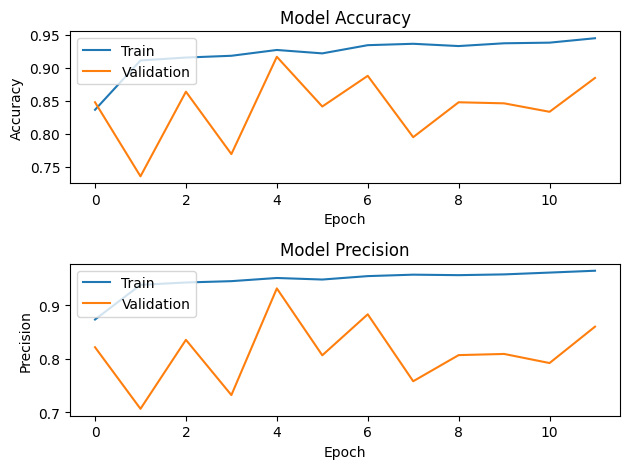

In [ ]:
# `history.history` is a dictionary containing the training and validation metrics

# Plotting accuracy
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1 (top subplot)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting precision
plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot 2 (bottom subplot)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust subplot layout to avoid overlap

# Show plot
plt.show()


In [ ]:
# Save the model as an HDF5 file
model.save('chest_xray_model.h5')

In [3]:
# Define a function to make predictions
def diagnosis(img_path):
    # Load the image from file
    img = image.load_img(img_path, target_size=(256, 256))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand the dimensions to match the model's expected input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Use the model to predict
    prediction=model.predict(img_array)
    if prediction<=0.5:
       print('Normal.')
    else:
      print('Pneumonia.')


In [ ]:
# Example usage 1
image_path_1="/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-186900-0001.jpeg"
diagnosis(image_path_1)

1/1 [==============================] - 0s 68ms/step
Normal.


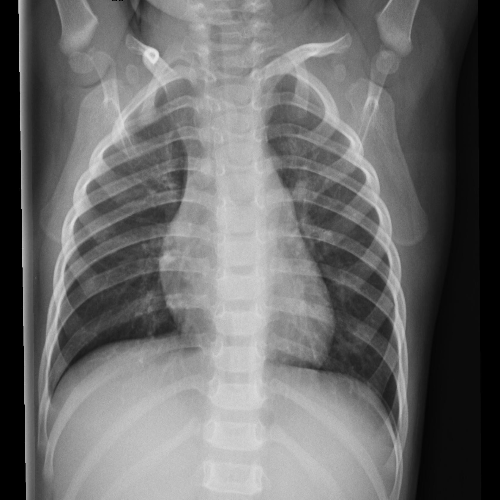

In [ ]:
# Read  image_1
image = cv2.imread(image_path_1)

# Resize the image
width, height = 500, 500  # Adjust the width and height as needed
resized_image = cv2.resize(image, (width, height))

# Display the resized image
cv2_imshow(resized_image)


In [ ]:
# Example usage 2
image_path_2="/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1351146-0002.jpeg"
diagnosis(image_path_2)

1/1 [==============================] - 0s 67ms/step
Pneumonia.


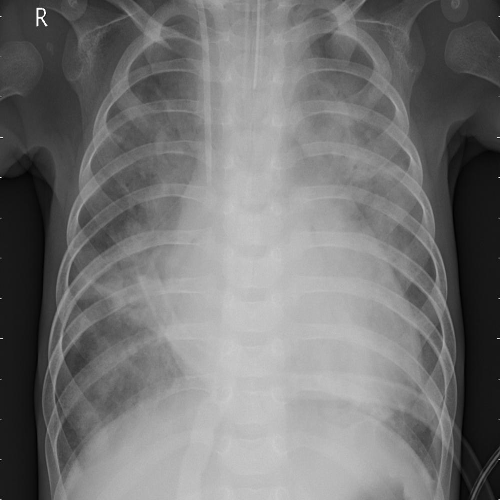

In [ ]:
# Read  image_2
image = cv2.imread(image_path_2)

# Resize the image
width, height = 500, 500  # Adjust the width and height as needed
resized_image = cv2.resize(image, (width, height))

# Display the resized image
cv2_imshow(resized_image)


In [ ]:
inputs = gr.inputs.Image(shape=(256,256))
outputs = gr.outputs.Label(num_top_classes=2)

gr.Interface(diagnosis, inputs, outputs, capture_session=True).launch()#gr interface
